# Vehicle Detection

## Overview

This notebook contains an implementation to identify vehicles in a video from a front-facing camera on a car. The test images and project video are located in this [repository](https://github.com/abmantha/CarND-Vehicle-Detection).

The goals / steps of this project are the following: 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import glob
import time

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load Test Images

In [2]:
%matplotlib inline
# test_images_paths = ["test_images/test*.jpg", "test_images/kitti*.png", "test_images/kitti-main*.png"]
test_images_paths = ["test_images/test*.jpg"]
test_images = glob.glob(test_images_paths[0])
# test_kitti_extracted_images = glob.glob(test_images_paths[1])
# test_kitti_main_images = glob.glob(test_images_paths[2])

cars_images_paths = ["../CarND-Data-Vehicle-Detection/vehicles/GTI_Far/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Left/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_MiddleClose/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Right/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/KITTI_extracted/*.png"]

non_cars_images_paths = ["../CarND-Data-Vehicle-Detection/non-vehicles/Extras/extra*.png",
                         "../CarND-Data-Vehicle-Detection/non-vehicles/GTI/image*.png"]

cars = glob.glob(cars_images_paths[0])
cars.extend(glob.glob(cars_images_paths[1]))
cars.extend(glob.glob(cars_images_paths[2]))
cars.extend(glob.glob(cars_images_paths[3]))
cars.extend(glob.glob(cars_images_paths[4]))

non_cars = glob.glob(non_cars_images_paths[0])
non_cars.extend(glob.glob(non_cars_images_paths[1]))

print ("Length of cars dataset: ", len(cars))
print ("Length of non-cars dataset: ", len(non_cars))

Length of cars dataset:  8792
Length of non-cars dataset:  8968


## Plot Utility Functions

In [ ]:
def plot_color_histogram(hist_channels, bin_centers, features): 
    if len(hist_channels) != 0: 
        fig = plt.figure(figsize=(12,3))

        plt.subplot(131)
        plt.bar(bin_centers, hist_channels[0][0])
        plt.xlim(0, 256)
        plt.title('Channel 1 Histogram')
        
        plt.subplot(132)
        plt.bar(bin_centers, hist_channels[1][0])
        plt.xlim(0, 256)
        plt.title('Channel 2 Histogram')
        
        plt.subplot(133)
        plt.bar(bin_centers, hist_channels[2][0])
        plt.xlim(0, 256)
        plt.title('Channel 3 Histogram')
        
        plt.show()
    else: 
        print ("Error with your function")
        
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]): 
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), 
        edgecolors='none'
    )
    
    return ax

## Plotting

In [ ]:
image = mpimg.imread(fname)
hist_channels, bin_centers, feature_vec = color_histogram(image, 32, (0, 256))    
plot_color_histogram(hist_channels, bin_centers, feature_vec)

img_name = kitti_extracted_images[0]
img = cv2.imread(img_name)
copy = np.copy(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

scale = max(copy.shape[0], copy.shape[1], 64) / 64
img_small = cv2.resize(copy, (np.int(copy.shape[1] / scale), np.int(copy.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2Luv)
img_small_rgb = img_small_RGB / 255.

plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

## Pipeline Utilities

In [3]:
def generate_dataset_dict(car_list, not_car_list): 
    example_image = cv2.imread(car_list[0])
    data_dict = {}    
    data_dict["n_cars"] = len(car_list)
    data_dict["n_not_cars"] = len(not_car_list)
    data_dict["image_shape"] = example_image.shape
    data_dict["data_type"] = example_image.dtype
    return data_dict

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale,svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32, 32), hist_bins=32):
        
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    return rectangles, draw_img


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list): 
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold): 
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Parameter Tuning and Feature Extraction

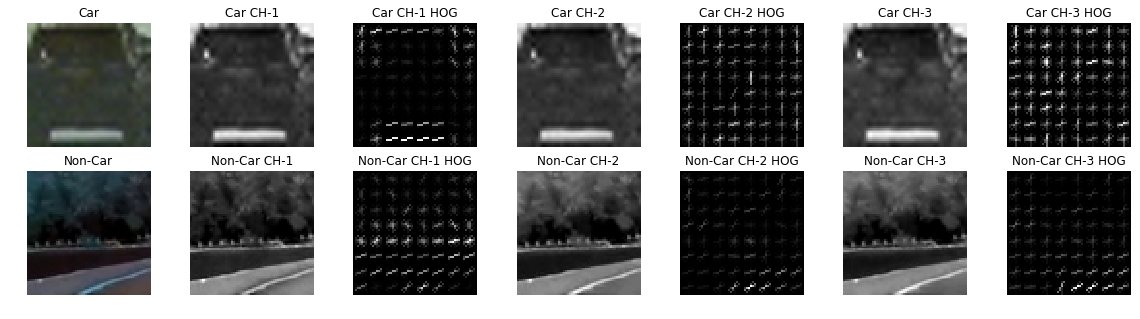

In [4]:
import random
rand_car_index = random.randint(0, len(cars))
rand_car_image = cv2.imread(cars[rand_car_index])

rand_non_index = random.randint(0, len(non_cars))
rand_non_image = cv2.imread(non_cars[rand_non_index])

def parameter_tuning_and_plot(car_image, non_car_image, orient, color_space, pix_per_cell, cell_per_block): 
    if (color_space != None):
        car_feature_image = cv2.cvtColor(car_image, color_space)
        non_car_feature_image = cv2.cvtColor(non_car_image, color_space)
    else:
        car_feature_image = np.copy(car_image)
        non_car_feature_image = np.copy(non_car_image)

    car_hog_features_1, car_hog_image_1 = get_hog_features(car_feature_image[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    car_hog_features_2, car_hog_image_2 = get_hog_features(car_feature_image[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    car_hog_features_3, car_hog_image_3 = get_hog_features(car_feature_image[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_1, non_car_hog_image_1 = get_hog_features(non_car_feature_image[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_2, non_car_hog_image_2 = get_hog_features(non_car_feature_image[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    non_car_hog_features_3, non_car_hog_image_3 = get_hog_features(non_car_feature_image[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        
    fig, axis = plt.subplots(2, 7, figsize=(20, 5))
    axis = axis.ravel()
    
    axis[0].imshow(car_image)
    axis[0].axis('off')
    axis[0].set_title("Car")
    
    axis[1].imshow(car_image[:, :, 0], cmap="gray")
    axis[1].axis('off')
    axis[1].set_title("Car CH-1")
    
    axis[2].imshow(car_hog_image_1, cmap="gray")
    axis[2].axis('off')
    axis[2].set_title("Car CH-1 HOG")
    
    axis[3].imshow(car_image[:, :, 1], cmap="gray")
    axis[3].axis('off')
    axis[3].set_title("Car CH-2")
        
    axis[4].imshow(car_hog_image_2, cmap="gray")
    axis[4].axis('off')
    axis[4].set_title("Car CH-2 HOG")
    
    axis[5].imshow(car_image[:, :, 2], cmap="gray")
    axis[5].axis('off')
    axis[5].set_title("Car CH-3")
    
    axis[6].imshow(car_hog_image_3, cmap="gray")
    axis[6].axis('off')
    axis[6].set_title("Car CH-3 HOG")

    axis[7].imshow(non_car_image)
    axis[7].axis('off')
    axis[7].set_title("Non-Car")
    
    axis[8].imshow(non_car_image[:, :, 0], cmap="gray")
    axis[8].axis('off')
    axis[8].set_title("Non-Car CH-1")
    
    axis[9].imshow(non_car_hog_image_1, cmap="gray")
    axis[9].axis('off')
    axis[9].set_title("Non-Car CH-1 HOG")
    
    axis[10].imshow(non_car_image[:, :, 1], cmap="gray")
    axis[10].axis('off')
    axis[10].set_title("Non-Car CH-2")
    
    axis[11].imshow(non_car_hog_image_2, cmap="gray")
    axis[11].axis('off')
    axis[11].set_title("Non-Car CH-2 HOG")
         
    axis[12].imshow(non_car_image[:, :, 2], cmap="gray")
    axis[12].axis('off')
    axis[12].set_title("Non-Car CH-3")
    
    axis[13].imshow(non_car_hog_image_3, cmap="gray")
    axis[13].axis('off')
    axis[13].set_title("Non-Car CH-3 HOG")
    
parameter_tuning_and_plot(rand_car_image, rand_non_image, 9, cv2.COLOR_RGB2YCrCb, 8, 2)

## SVM Training

__Experiment 1: Hist + HOG__
* Color Space: HLS
* Orient = 11
* Pix per Cell = 8
* Cell per Block = 2
* HOG Channel = 2
* Hist Bins = 32
* Y Min = image_shape[1]//2
* Y Max = image_shape[1] - 100
* __RESULTS__: Feature vector length: 2252 | 5.3 Seconds to train SVC... | Test Accuracy of SVC =  0.9738

__Experiment 2: Hist + Spatial + HOG__
* Color Space: YCrCb
* Orient = 9
* Pix per Cell = 8
* Cell per Block = 2
* HOG Channel = "ALL"
* Spatial Size = 32, 32
* Hist Bins = 32
* Y Min = image_shape[1]//2
* Y Max = image_shape[1] - 100
* __RESULTS__: Feature vector length: 8460 | 26.11 Seconds to train SVC... | Test Accuracy of SVC =  0.9896
* __RESULTS__: Feature vector length: 8460 | 23.99 Seconds to train SVC... | Test Accuracy of SVC =  0.9893
* __RESULTS__: Feature vector length: 8460 | 22.89 Seconds to train SVC... | Test Accuracy of SVC =  0.987

__Experiment 3: HOG (test purposes only)__
* __RESULTS__: Feature vector length: 5292 | 7.25 Seconds to train SVC... | Test Accuracy of SVC =  0.9783

In [5]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_cars = cars
sample_non_cars = non_cars

image = mpimg.imread(test_images[0])
image_shape = (image.shape[1], image.shape[0])
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [image_shape[1]//2, image_shape[1]-100] # Min and max in y to search in slide_window()

car_features = extract_features(sample_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(sample_non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ("Features are extracted")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print ("Applying normalization scaler")

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Features are extracted
Applying normalization scaler
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
24.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


# Complete Pipeline

In [35]:
def pipeline(image):
#     test_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_img = np.copy(image)
    
    color_space = cv2.COLOR_RGB2YCrCb # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins

    ystart = 400
    ystop = 600
    scale = 1.3

    rectangles, out_image = find_cars(test_img, ystart, ystop, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    # rectangles = [item for sublist in rects for item in sublist] 
    # test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)

    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat, 3) # apply a greater threshold
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

## Testing Pipeline 

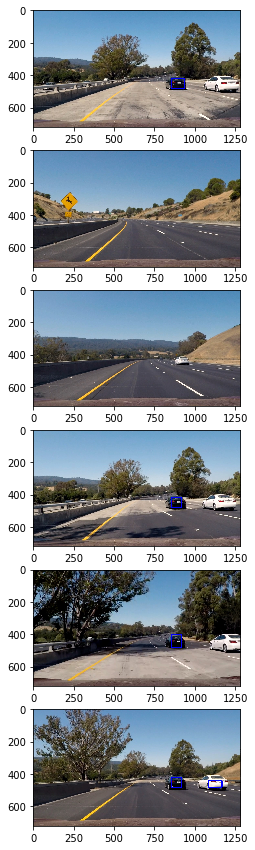

In [36]:
# for fname in test_images: 
#     ystart = 400
#     ystop = 700
#     scale = 2.5

#     image = cv2.imread(fname)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     pipelined_window = pipeline(image)
#     fig, axis = plt.subplots(1, 1, figsize=(10, 10))
#     axis.imshow(pipelined_window)

# test_img = cv2.imread(test_images[4])
fig, axis = plt.subplots(6, 1, figsize=(15, 15))
axis = axis.ravel()
for i, fname in enumerate(test_images): 
    single_test_image = mpimg.imread(fname)
    single_test_out_image = pipeline(single_test_image)
    axis[i].imshow(single_test_out_image)

# Video Playback

### Test Video

In [37]:
test_video_outname = "test_video_with_detection.mp4"
test_video = VideoFileClip("test_video.mp4")
test_video_updated = test_video.fl_image(pipeline)
%time test_video_updated.write_videofile(test_video_outname, audio=False)

[MoviePy] >>>> Building video test_video_with_detection.mp4
[MoviePy] Writing video test_video_with_detection.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.12it/s]      | 1/39 [00:00<00:13,  2.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_with_detection.mp4 

CPU times: user 11.9 s, sys: 470 ms, total: 12.4 s
Wall time: 13 s


In [38]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(test_video_outname))

# Project Video

In [ ]:
project_video_outname = "project_video_with_detection.mp4"
project_video = VideoFileClip("project_video.mp4")
project_video_updated = project_video.fl_image(pipeline)
%time project_video_updated.write_videofile(project_video_outname, audio=False)

In [ ]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(project_video_outname))